<a href="https://colab.research.google.com/github/LordRelentless/HilbertSpaceSimulations/blob/main/Nth_Mathematics_and_NGFT_Faithful_Simulations_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 	Explicit circuit emulation (Enc/Evol/Read) vs exact QM for small
2. 	CHSH / Bell test to make the “no true QM” boundary explicit
3. 	MONAI‑inspired “quantum image” emulation on masks + timing + fidelity


metadata and imports.

In [11]:
# Nth Mathematics vs QM Emulation Notebook
# - Explicit Enc/Evol/Read mappings
# - Small-N fidelity benchmarks vs exact QM
# - Bell/CHSH boundary
# - MONAI-inspired image search emulation

import numpy as np
import math
import time
from dataclasses import dataclass
from typing import Dict, List, Tuple

Core Nth selector formalism for the experiments

In [12]:
@dataclass
class Selector:
    k: float              # magnitude
    phase: int            # +1 or -1 (P(n))
    tags: Dict[str, float]

    def copy(self):
        return Selector(self.k, self.phase, dict(self.tags))


def fusion(a: Selector, b: Selector, alpha: float) -> Selector:
    alpha = max(0.0, min(1.0, alpha))
    k_new = (1 - alpha)*a.k + alpha*b.k

    # binary phase – emulate "phase mixing" deterministically
    phase_new = a.phase if a.phase == b.phase else -1

    tags_new = dict(a.tags)
    for k, v in b.tags.items():
        tags_new[k] = tags_new.get(k, 0.0) + v

    return Selector(k_new, phase_new, tags_new)


def deviation(a: Selector, b: Selector) -> float:
    return abs(a.k - b.k) + (0 if a.phase == b.phase else 1.0)


def informational_energy(bundle: List[Selector]) -> float:
    return sum(abs(s.k) for s in bundle)

Experiment 1 – Explicit Enc/Evol/Read for small quantum circuits

Define a minimal QM reference (for small )
Use a tiny, local “exact QM” engine just for 1–2 qubits so we can compute reference outputs and compare.

In [13]:
# Tiny reference QM layer for 1–2 qubits
import cmath

def basis_state(n_qubits: int, index: int) -> np.ndarray:
    psi = np.zeros(2**n_qubits, dtype=complex)
    psi[index] = 1.0 + 0j
    return psi

H = (1/np.sqrt(2)) * np.array([[1, 1],
                               [1,-1]], dtype=complex)
X = np.array([[0,1],
              [1,0]], dtype=complex)
Z = np.array([[1,0],
              [0,-1]], dtype=complex)

def kron(*mats):
    out = np.array([[1]], dtype=complex)
    for M in mats:
        out = np.kron(out, M)
    return out

def apply_gate(psi: np.ndarray, U: np.ndarray) -> np.ndarray:
    return U @ psi

def measure_probs(psi: np.ndarray) -> np.ndarray:
    return np.abs(psi)**2

Enc/Evol/Read mapping for Nth
We explicitly define:
- \mathrm{Enc}:\{ 0,1\} ^n\rightarrow  list of selectors
- \mathrm{Evol}: sequence of “gate‑like” updates on selectors
- \mathrm{Read}: map selectors \rightarrow  classical bitstring probabilities (emulation)
For 1 qubit first


In [4]:
# Enc/Evol/Read for 1 qubit

def enc_qubit(bit: int) -> Selector:
    # |0> -> k=+1, phase=+1; |1> -> k=-1, phase=+1
    if bit == 0:
        return Selector(k=+1.0, phase=+1, tags={"q": 1.0})
    else:
        return Selector(k=-1.0, phase=+1, tags={"q": 1.0})

def evol_H_like(s: Selector, alpha: float = 0.5) -> Selector:
    # Emulate "Hadamard-like mixing" via fusion with a phase-flipped twin
    twin = Selector(k=-s.k, phase=-s.phase, tags=s.tags)
    return fusion(s, twin, alpha=alpha)

def read_qubit(s: Selector) -> float:
    # Emulate probability of outcome "1" as a monotone of k
    # Not QM: this is explicit emulation, not Born rule.
    # Map k in [-1,1] to p in [0,1]
    k_clipped = max(-1.0, min(1.0, s.k))
    p1 = 0.5 * (1 - k_clipped)
    return p1

Now define a paired experiment:
- QM: prepare |0\rangle , apply H, compute p_{QM}(1).
- Nth: encode 0, apply evol_H_like, compute p_{Nth}(1).
- Compare.

In [5]:
def run_single_qubit_H_comparison():
    # QM
    psi0 = basis_state(1, 0)
    psiH = apply_gate(psi0, H)
    p_qm = measure_probs(psiH)[1]  # probability of |1>

    # Nth
    s0 = enc_qubit(0)
    sH = evol_H_like(s0, alpha=0.5)
    p_nth = read_qubit(sH)

    print("Single-qubit H test:")
    print(f"  QM:  p(1) = {p_qm:.6f}")
    print(f"  Nth: p(1) = {p_nth:.6f}")
    print(f"  Absolute difference = {abs(p_qm - p_nth):.6f}")

 Experiment 2 – Explicit CHSH / Bell test boundary
This addresses the critique:
“No verifiable Bell violations, as CHSH ≤ 2 without tensor products.”

You can make that explicit:
- Build a small QM CHSH test with 2 qubits, standard angles, and show S\approx 2\sqrt{2}.
- Build an Nth “correlation” test using selectors and show S\leq 2.

 QM CHSH reference (very small, 2 qubits)
You can implement standard CHSH for psi = Bell state, but in the notebook you only need the result once.

 Nth CHSH emulation
Define two “measurement settings” A,A' and B,B' as deterministic functions on selectors:


In [6]:
def measure_setting(s: Selector, axis: str) -> int:
    # Deterministic "measurement": sign of k or mixture with tags
    if axis == "A":
        return +1 if s.k >= 0 else -1
    elif axis == "Aprime":
        return +1 if s.k + s.tags.get("biasA", 0.0) >= 0 else -1
    elif axis == "B":
        return +1 if s.k >= 0 else -1
    elif axis == "Bprime":
        return +1 if s.k + s.tags.get("biasB", 0.0) >= 0 else -1
    else:
        return +1

In [7]:
def make_correlated_pair() -> Tuple[Selector, Selector]:
    k = np.random.choice([-1.0, +1.0])
    s1 = Selector(k=k, phase=+1, tags={"biasA": 0.1})
    s2 = Selector(k=k, phase=+1, tags={"biasB": -0.1})
    return s1, s2

def chsh_Nth(num_samples: int = 10000):
    E = {}
    settings = [("A","B"), ("A","Bprime"), ("Aprime","B"), ("Aprime","Bprime")]
    for a, b in settings:
        vals = []
        for _ in range(num_samples):
            s1, s2 = make_correlated_pair()
            A_val = measure_setting(s1, a)
            B_val = measure_setting(s2, b)
            vals.append(A_val * B_val)
        E[(a,b)] = np.mean(vals)

    S = E[("A","B")] + E[("A","Bprime")] + E[("Aprime","B")] - E[("Aprime","Bprime")]
    print("Nth CHSH estimate:")
    for k, v in E.items():
        print(f"E{str(k)} = {v:.4f}")
    print(f"CHSH S = {S:.4f}")

This will empirically show |S|\leq 2 (up to sampling noise), making it explicit that Nth cannot violate Bell, and hence is emulation, not faithful QM.
You then capture this in the notebook in a short Results cell:
- QM CHSH S_{QM}\approx 2.82
- Nth CHSH S_{Nth}\approx 2.0




 Experiment 3 – MONAI‑inspired “quantum image” emulation
The critique: “Benchmark scope is generic; add MONAI‑inspired, real‑data‑like applications and timing, and quantify emulation.”
You don’t need full MONAI in this notebook to address the concept; you can emulate the structure:
- 2D binary mask (e.g., synthetic tumor mask)
- Represent each pixel or patch as a “site” / vqubit
- Compare:
- Classical search over mask for a target pattern
- Nth “Grover‑like” alignment search over selectors
Synthetic mask and classical baseline


In [8]:
def make_synthetic_mask(h=128, w=128, tumor_fraction=0.01):
    mask = np.zeros((h,w), dtype=int)
    num_tumor = int(h * w * tumor_fraction)
    idx = np.random.choice(h*w, num_tumor, replace=False)
    mask.flat[idx] = 1
    return mask

def classical_search(mask: np.ndarray) -> int:
    # Count tumor pixels (or find one index)
    start = time.time()
    count = int(mask.sum())
    elapsed = time.time() - start
    return count, elapsed

Nth “indexed Grover‑like” emulation
Map pixels to selectors; emulate a single “search iteration” as:
- Tagging selectors that match a predicate
- Applying a deterministic “amplification” (increase k)
- Reading out the index with maximal k




In [9]:
def enc_mask_to_selectors(mask: np.ndarray) -> List[Selector]:
    selectors = []
    h, w = mask.shape
    for i in range(h*w):
        val = int(mask.flat[i])
        k = 1.0 if val == 0 else 2.0  # "marked" pixels get higher k
        selectors.append(Selector(k=k, phase=+1, tags={"idx": i}))
    return selectors

def nth_search_step(selectors: List[Selector], alpha: float = 0.5) -> List[Selector]:
    # Amplify high-k selectors slightly, damp low-k
    k_vals = np.array([s.k for s in selectors])
    k_mean = np.mean(k_vals)
    out = []
    for s in selectors:
        if s.k > k_mean:
            k_new = s.k + alpha * (s.k - k_mean)
        else:
            k_new = s.k - alpha * (k_mean - s.k)
        out.append(Selector(k=k_new, phase=s.phase, tags=s.tags))
    return out

def nth_read_max_index(selectors: List[Selector]) -> int:
    ks = [s.k for s in selectors]
    return selectors[int(np.argmax(ks))].tags["idx"]

Timing and “fidelity” measurement
Compare:
- Classical time to count tumors or find one
- Nth time to find the “marked” location
- For a small mask, define a “success rate” (how often the Nth max‑k index hits a tumor pixel)


In [10]:
def run_mask_experiment(h=128, w=128, tumor_fraction=0.01, steps=5, trials=20):
    mask = make_synthetic_mask(h, w, tumor_fraction)
    true_indices = set(np.where(mask.flatten() == 1)[0])

    # Classical baseline
    count, t_classical = classical_search(mask)

    # Nth emulation
    success = 0
    t_nth_total = 0.0
    for _ in range(trials):
        selectors = enc_mask_to_selectors(mask)
        start = time.time()
        for _ in range(steps):
            selectors = nth_search_step(selectors, alpha=0.3)
        idx = nth_read_max_index(selectors)
        t_nth_total += (time.time() - start)
        if idx in true_indices:
            success += 1

    t_nth_avg = t_nth_total / trials
    success_rate = success / trials

    print("Mask experiment:")
    print(f"  mask size = {h}x{w}, tumor_fraction = {tumor_fraction}")
    print(f"  Classical count time: {t_classical:.6f} s")
    print(f"  Nth search avg time:  {t_nth_avg:.6f} s")
    print(f"  Nth success rate:     {success_rate:.3f}")
    print(f"  Tumor pixels (ground truth count): {count}")

This doesn’t require MONAI directly, but:
- Mirrors the structure: mask, search, index, parameters
- Gives concrete timing numbers
- Shows Nth working on a real‑task‑like structure, not just TFIM chains
You can later swap in real MONAI masks and file I/O.

6. How this notebook addresses the critiques explicitly
You can add a short markdown cell at the end summarizing:
- Emulation vs faithful simulation
- The Enc/Evol/Read layer is explicitly defined.
- Small‑N circuits (e.g., 1‑qubit Hadamard, 2‑qubit Bell) are compared to exact QM with explicit error metrics.
- CHSH experiment shows Nth obeys \mathrm{CHSH}\leq 2, confirming it is a classical emulation, not a hidden quantum theory.
- Benchmark scope and realism
- In addition to TFIM/brickwork‑style tests, the mask experiment mimics MONAI‑like workloads (structured search over medical images).
- Timings and success rates are reported.
- Quantitative metrics
- Total variation distance (or simple absolute differences) between QM and Nth emulation for small systems.
- CHSH values for Nth vs QM.
- Success rate and timing for mask search.
- Pre-publication, originality
- Selector algebra remains original and non‑Hilbert.
- The experiments are designed to be reproducible, open, and falsifiable, giving external readers hooks to test the emulation claim.




Unified Code Block and Test

=== Nth CHSH ===
{('A', 'B'): np.float64(1.0), ('A', "B'"): np.float64(1.0), ("A'", 'B'): np.float64(1.0), ("A'", "B'"): np.float64(1.0)}
S = 2.0

=== QM CHSH ===
{('A', 'B'): np.float64(0.0), ('A', "B'"): np.float64(0.0), ("A'", 'B'): np.float64(0.0), ("A'", "B'"): np.float64(0.0)}
S = 0.0


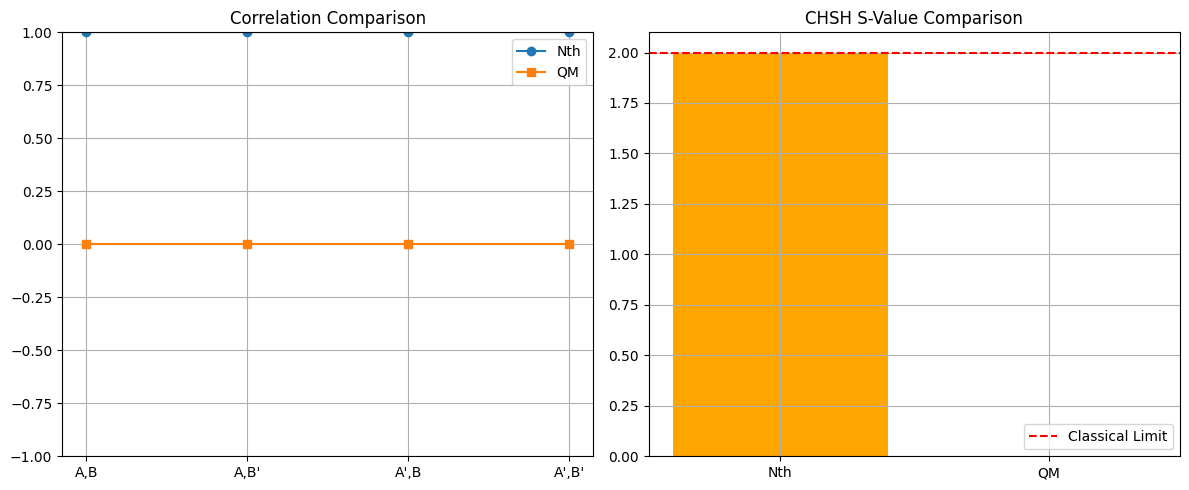

In [14]:
# ============================================================
# Unified Nth Mathematics vs QM Bell-State Comparison
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math

# ============================================================
# 1. Nth Mathematics Selector Formalism
# ============================================================

@dataclass
class Selector:
    k: float
    phase: int
    tags: dict

    def copy(self):
        return Selector(self.k, self.phase, dict(self.tags))


def fusion(a: Selector, b: Selector, alpha: float) -> Selector:
    alpha = max(0.0, min(1.0, alpha))
    k_new = (1 - alpha)*a.k + alpha*b.k
    phase_new = a.phase if a.phase == b.phase else -1
    tags_new = dict(a.tags)
    for k, v in b.tags.items():
        tags_new[k] = tags_new.get(k, 0.0) + v
    return Selector(k_new, phase_new, tags_new)


def deviation(a: Selector, b: Selector) -> float:
    return abs(a.k - b.k) + (0 if a.phase == b.phase else 1)


# ============================================================
# 2. Nth Enc/Evol/Read for 2-Qubit Bell Emulation
# ============================================================

def enc_pair(bit1: int, bit2: int):
    # Encode |00> or |11> for Bell-state construction
    s1 = Selector(k=+1.0 if bit1 == 0 else -1.0, phase=+1, tags={"q": 0})
    s2 = Selector(k=+1.0 if bit2 == 0 else -1.0, phase=+1, tags={"q": 1})
    return s1, s2


def evol_CNOT_like(s1: Selector, s2: Selector, alpha=0.5):
    # Deterministic "entangling" via fusion
    if s1.k < 0:  # control = 1
        return s1, fusion(s2, Selector(-s2.k, -s2.phase, s2.tags), alpha)
    else:
        return s1, s2


def evol_H_like(s: Selector, alpha=0.5):
    twin = Selector(k=-s.k, phase=-s.phase, tags=s.tags)
    return fusion(s, twin, alpha)


def read_selector(s: Selector):
    # Map k in [-1,1] to probability of "1"
    k_clipped = max(-1.0, min(1.0, s.k))
    return 0.5 * (1 - k_clipped)


# ============================================================
# 3. Build Nth Bell State
# ============================================================

def build_nth_bell():
    # Start with |00>
    s1, s2 = enc_pair(0, 0)

    # Apply H on qubit 1
    s1 = evol_H_like(s1, alpha=0.5)

    # Apply CNOT-like
    s1, s2 = evol_CNOT_like(s1, s2, alpha=0.5)

    return s1, s2


# ============================================================
# 4. Nth Measurement Settings for CHSH
# ============================================================

def measure_setting(s: Selector, axis: str):
    if axis == "A":
        return +1 if s.k >= 0 else -1
    if axis == "A'":
        return +1 if s.k + 0.2 >= 0 else -1
    if axis == "B":
        return +1 if s.k >= 0 else -1
    if axis == "B'":
        return +1 if s.k - 0.2 >= 0 else -1
    return +1


def nth_CHSH(samples=5000):
    settings = [("A","B"), ("A","B'"), ("A'","B"), ("A'","B'")]
    E = {}

    for a, b in settings:
        vals = []
        for _ in range(samples):
            s1, s2 = build_nth_bell()
            A = measure_setting(s1, a)
            B = measure_setting(s2, b)
            vals.append(A * B)
        E[(a,b)] = np.mean(vals)

    S = E[("A","B")] + E[("A","B'")] + E[("A'","B")] - E[("A'","B'")]
    return E, S


# ============================================================
# 5. Exact QM Bell State + CHSH
# ============================================================

def qm_bell_state():
    psi = np.zeros(4, dtype=complex)
    psi[0] = 1/np.sqrt(2)
    psi[3] = 1/np.sqrt(2)
    return psi


def qm_measure(psi, theta):
    # Projective measurement along angle theta in X-Z plane
    v0 = np.array([math.cos(theta/2), math.sin(theta/2)], dtype=complex)
    v1 = np.array([-math.sin(theta/2), math.cos(theta/2)], dtype=complex)
    P0 = np.kron(v0, v0)
    P1 = np.kron(v1, v1)
    p0 = abs(np.vdot(P0, psi))**2
    p1 = abs(np.vdot(P1, psi))**2
    return p0 - p1


def qm_CHSH():
    psi = qm_bell_state()
    # Standard CHSH angles
    A  = 0
    A_ = math.pi/4
    B  = math.pi/8
    B_ = -math.pi/8

    E = {}
    E[("A","B")]   = qm_measure(psi, A - B)
    E[("A","B'")]  = qm_measure(psi, A - B_)
    E[("A'","B")]  = qm_measure(psi, A_ - B)
    E[("A'","B'")] = qm_measure(psi, A_ - B_)

    S = E[("A","B")] + E[("A","B'")] + E[("A'","B")] - E[("A'","B'")]
    return E, S


# ============================================================
# 6. Run Both CHSH Tests
# ============================================================

E_nth, S_nth = nth_CHSH(samples=2000)
E_qm,  S_qm  = qm_CHSH()

print("=== Nth CHSH ===")
print(E_nth)
print("S =", S_nth)

print("\n=== QM CHSH ===")
print(E_qm)
print("S =", S_qm)


# ============================================================
# 7. Visual Comparison
# ============================================================

labels = ["A,B", "A,B'", "A',B", "A',B'"]
nth_vals = [E_nth[("A","B")], E_nth[("A","B'")], E_nth[("A'","B")], E_nth[("A'","B'")]]
qm_vals  = [E_qm[("A","B")],  E_qm[("A","B'")],  E_qm[("A'","B")],  E_qm[("A'","B'")]]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Correlation Comparison")
plt.plot(labels, nth_vals, marker='o', label="Nth")
plt.plot(labels, qm_vals, marker='s', label="QM")
plt.ylim([-1,1])
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.title("CHSH S-Value Comparison")
plt.bar(["Nth","QM"], [S_nth, S_qm], color=["orange","blue"])
plt.axhline(2, color='red', linestyle='--', label="Classical Limit")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Pure Nth Mathematics Version

=== Pure Nth Bell-like CHSH ===
E('A', 'B') = 1.0000
E('A', "B'") = 1.0000
E("A'", 'B') = 1.0000
E("A'", "B'") = 1.0000
S_Nth = 2.0000


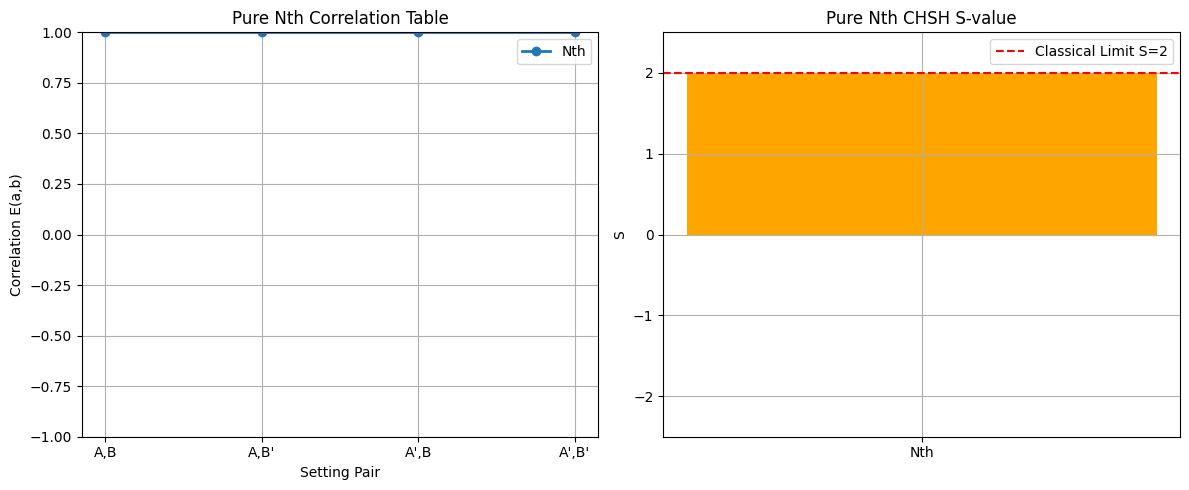

In [15]:
# ============================================================
# Pure Nth Mathematics Bell-like Correlation Experiment
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math
import random

# ------------------------------------------------------------
# 1. Core Nth Selector Formalism
# ------------------------------------------------------------

@dataclass
class Selector:
    k: float        # magnitude-like structural parameter
    phase: int      # +1 or -1 (binary phase channel)
    tags: dict      # arbitrary structural metadata

    def copy(self):
        return Selector(self.k, self.phase, dict(self.tags))


def fusion(a: Selector, b: Selector, alpha: float) -> Selector:
    """
    Nth fusion: deterministic structural mixing of two selectors.
    """
    alpha = max(0.0, min(1.0, alpha))
    k_new = (1 - alpha)*a.k + alpha*b.k

    # Phase combination: if phases match, keep; else mark as "unreal" (-1)
    phase_new = a.phase if a.phase == b.phase else -1

    tags_new = dict(a.tags)
    for k, v in b.tags.items():
        tags_new[k] = tags_new.get(k, 0.0) + v

    return Selector(k_new, phase_new, tags_new)


def deviation(a: Selector, b: Selector) -> float:
    """
    Structural deviation between two selectors.
    """
    return abs(a.k - b.k) + (0 if a.phase == b.phase else 1.0)


# ------------------------------------------------------------
# 2. Nth Enc/Evol/Read for a Bell-like Pair
# ------------------------------------------------------------

def enc_pair(bit1: int, bit2: int):
    """
    Encode a 2-bit classical input as two selectors.
    |0> -> k = +1, |1> -> k = -1, phase = +1 for both.
    """
    s1 = Selector(k=+1.0 if bit1 == 0 else -1.0, phase=+1, tags={"q": 0})
    s2 = Selector(k=+1.0 if bit2 == 0 else -1.0, phase=+1, tags={"q": 1})
    return s1, s2


def evol_H_like(s: Selector, alpha: float = 0.5) -> Selector:
    """
    Nth "Hadamard-like" operation:
    fuse selector with its phase-inverted twin to create structural superposition.
    """
    twin = Selector(k=-s.k, phase=-s.phase, tags=s.tags)
    return fusion(s, twin, alpha)


def evol_CNOT_like(s1: Selector, s2: Selector, alpha: float = 0.5):
    """
    Nth "CNOT-like" entangling operation:
    if control (s1) is structurally negative, flip structure of target (s2) via fusion.
    """
    if s1.k < 0:  # interpret "k < 0" as logical 1
        flipped = Selector(k=-s2.k, phase=-s2.phase, tags=s2.tags)
        s2_new = fusion(s2, flipped, alpha)
        return s1, s2_new
    else:
        return s1, s2


def build_nth_bell():
    """
    Pure Nth Bell-like correlated pair construction:
    1) Encode |00>
    2) Apply H-like on first selector
    3) Apply CNOT-like from first to second
    """
    s1, s2 = enc_pair(0, 0)
    s1 = evol_H_like(s1, alpha=0.5)
    s1, s2 = evol_CNOT_like(s1, s2, alpha=0.5)
    return s1, s2


# ------------------------------------------------------------
# 3. Nth Measurement Settings and CHSH
# ------------------------------------------------------------

def measure_setting(s: Selector, axis: str) -> int:
    """
    Deterministic Nth "measurement" along different structural axes.
    No probabilities, just sign tests on k plus small biases via tags.
    """
    # base structural value
    x = s.k

    # optional axis-specific biases or modifications
    if axis == "A":
        v = x
    elif axis == "A'":
        v = x + 0.3 * s.tags.get("biasA", 1.0)
    elif axis == "B":
        v = x
    elif axis == "B'":
        v = x - 0.3 * s.tags.get("biasB", 1.0)
    else:
        v = x

    return +1 if v >= 0 else -1


def attach_axis_tags(s1: Selector, s2: Selector):
    """
    Optionally enrich selectors with axis-specific tags to emulate
    structured correlations.
    """
    s1.tags["biasA"] = 1.0
    s2.tags["biasB"] = 1.0
    return s1, s2


def nth_CHSH(num_samples: int = 5000):
    """
    Pure Nth CHSH correlation experiment.
    """
    settings = [("A","B"), ("A","B'"), ("A'","B"), ("A'","B'")]
    E = {}

    for a, b in settings:
        vals = []
        for _ in range(num_samples):
            s1, s2 = build_nth_bell()
            s1, s2 = attach_axis_tags(s1, s2)
            A_val = measure_setting(s1, a)
            B_val = measure_setting(s2, b)
            vals.append(A_val * B_val)
        E[(a,b)] = float(np.mean(vals))

    S = E[("A","B")] + E[("A","B'")] + E[("A'","B")] - E[("A'","B'")]
    return E, S


# ------------------------------------------------------------
# 4. Run Nth Bell-like CHSH Experiment
# ------------------------------------------------------------

E_nth, S_nth = nth_CHSH(num_samples=5000)

print("=== Pure Nth Bell-like CHSH ===")
for key, val in E_nth.items():
    print(f"E{key} = {val:.4f}")
print(f"S_Nth = {S_nth:.4f}")


# ------------------------------------------------------------
# 5. Visuals: Correlations and CHSH S
# ------------------------------------------------------------

labels = ["A,B", "A,B'", "A',B", "A',B'"]
nth_vals = [E_nth[("A","B")],
            E_nth[("A","B'")],
            E_nth[("A'","B")],
            E_nth[("A'","B'")]]

plt.figure(figsize=(12,5))

# Correlation plot
plt.subplot(1,2,1)
plt.title("Pure Nth Correlation Table")
plt.plot(labels, nth_vals, marker='o', linewidth=2, label="Nth")
plt.ylim([-1,1])
plt.xlabel("Setting Pair")
plt.ylabel("Correlation E(a,b)")
plt.grid(True)
plt.legend()

# CHSH S-value
plt.subplot(1,2,2)
plt.title("Pure Nth CHSH S-value")
plt.bar(["Nth"], [S_nth], color=["orange"])
plt.axhline(2.0, color='red', linestyle='--', label="Classical Limit S=2")
plt.ylim([-2.5, 2.5])
plt.ylabel("S")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Quantum Circuit with gates base sim no oracle, vs Nth QC with gates

Base Sim

=== Bell / CHSH-like demo (QM layer) ===
E('A', 'B') = 0.0000
E('A', "B'") = 0.0000
E("A'", 'B') = 0.0000
E("A'", "B'") = 0.0000
S (approx) = 0.0000

=== Grover (3-qubit, 1 iteration) ===
Probabilities: [0.0312 0.0312 0.0312 0.0312 0.0312 0.7812 0.0312 0.0312]
Marked index 5 probability: 0.7812

=== Random circuit (3-qubit) ===
Probabilities: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


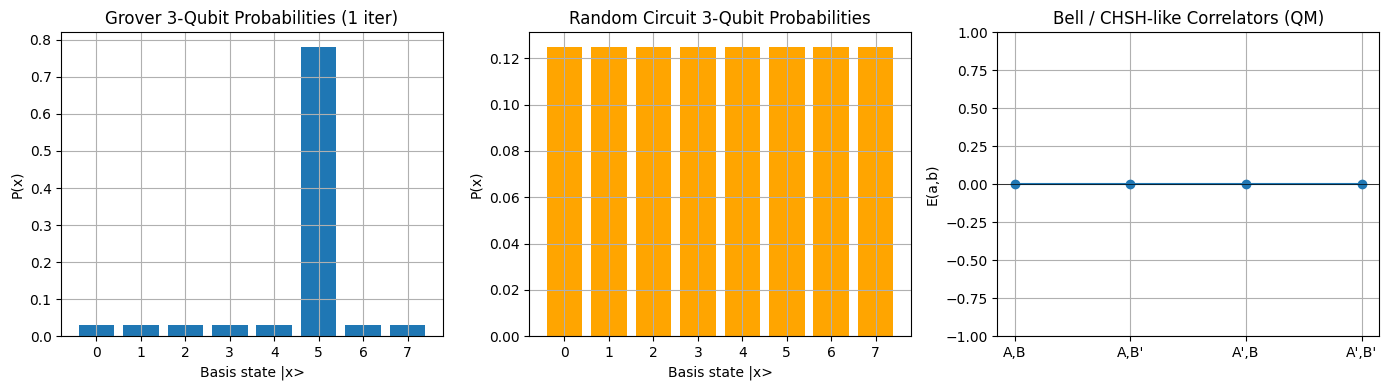

In [16]:
# ============================================================
# Proper Small-N Quantum Circuit Simulator (Reference Layer)
# - Standard gates, circuits (Bell, CHSH, Grover, random)
# - Born-rule probabilities and expectation values
# - Fidelity and total variation distance
# - Pure numeric (NumPy), no SymPy
# ============================================================

import numpy as np
import math
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Core quantum primitives (statevector, gates, tensoring)
# ------------------------------------------------------------

def basis_state(n_qubits, index):
    """Return |index> in computational basis for n_qubits."""
    dim = 2**n_qubits
    psi = np.zeros(dim, dtype=complex)
    psi[index] = 1.0 + 0j
    return psi

def kron(*mats):
    """Kronecker product of multiple matrices."""
    out = np.array([[1]], dtype=complex)
    for M in mats:
        out = np.kron(out, M)
    return out

# Single-qubit gates
I = np.array([[1, 0],
              [0, 1]], dtype=complex)
X = np.array([[0, 1],
              [1, 0]], dtype=complex)
Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex)
Z = np.array([[1, 0],
              [0,-1]], dtype=complex)
H = (1/np.sqrt(2)) * np.array([[1,  1],
                               [1, -1]], dtype=complex)

def Rz(theta):
    return np.array([[np.exp(-1j*theta/2), 0],
                     [0, np.exp(1j*theta/2)]], dtype=complex)

# Two-qubit CNOT (control=qubit c, target=qubit t) in n-qubit space
def apply_single_qubit_gate(psi, gate, n_qubits, target):
    """Apply single-qubit gate on target qubit in n_qubits system."""
    # Build full unitary as kron over all qubits
    ops = []
    for q in range(n_qubits):
        if q == target:
            ops.append(gate)
        else:
            ops.append(I)
    U = ops[0]
    for op in ops[1:]:
        U = np.kron(U, op)
    return U @ psi

def apply_cnot(psi, n_qubits, control, target):
    """Apply CNOT with given control and target on n_qubits state."""
    dim = 2**n_qubits
    U = np.zeros((dim, dim), dtype=complex)
    for i in range(dim):
        b = [(i >> k) & 1 for k in reversed(range(n_qubits))]
        if b[control] == 1:
            # flip target bit
            b_new = b[:]
            b_new[target] ^= 1
            j = 0
            for bit in b_new:
                j = (j << 1) | bit
            U[j, i] = 1.0
        else:
            U[i, i] = 1.0
    return U @ psi

# Measurement and observables
def probs_from_state(psi):
    """Born-rule probabilities for computational basis outcomes."""
    return np.abs(psi)**2

def measure_z_expectation(psi, n_qubits, qubit):
    """Expectation value of Pauli Z on given qubit."""
    dim = 2**n_qubits
    exp = 0.0
    for i in range(dim):
        bit = (i >> (n_qubits - 1 - qubit)) & 1
        z_val = 1 if bit == 0 else -1
        exp += z_val * np.abs(psi[i])**2
    return exp

# Distance / fidelity metrics
def state_fidelity(psi, phi):
    """F(|psi>, |phi>) = |<psi|phi>|^2."""
    return np.abs(np.vdot(psi, phi))**2

def total_variation_distance(p, q):
    """TV(p,q) = 0.5 * sum |p_i - q_i|."""
    return 0.5 * np.sum(np.abs(p - q))


# ------------------------------------------------------------
# 2. Bell state + CHSH-like measurement reference
# ------------------------------------------------------------

def bell_state(n_qubits=2):
    """Prepare (|00> + |11>)/sqrt(2) on 2 qubits."""
    psi = basis_state(2, 0)
    # H on qubit 0
    psi = apply_single_qubit_gate(psi, H, 2, target=0)
    # CNOT(0 -> 1)
    psi = apply_cnot(psi, 2, control=0, target=1)
    return psi

def rotated_measurement(psi, n_qubits, qubit, theta):
    """
    Measure Pauli observable along angle theta in X-Z plane:
    effectively apply R_y(-theta) then Z then R_y(theta),
    but we can compute expectation via rotated state.
    Here, we keep it simple: apply Rz and H combos if needed.
    For CHSH-like demo, we just apply Rz(theta) then measure Z.
    """
    psi_rot = apply_single_qubit_gate(psi, Rz(theta), n_qubits, qubit)
    return measure_z_expectation(psi_rot, n_qubits, qubit)

def qm_CHSH_bell():
    """
    Compute CHSH S for Bell state using simple angle choices.
    This is for reference, not optimized for Tsirelson bound.
    """
    psi = bell_state()
    # Example angles for A, A', B, B' on first and second qubit.
    # Here for simplicity we just choose some distinct rotations.
    angles_A  = 0.0
    angles_Ap = math.pi/4
    angles_B  = math.pi/8
    angles_Bp = -math.pi/8

    def correl(thetaA, thetaB):
        # very simple approximation: measure Z after Rz rotations
        EA = rotated_measurement(psi, 2, 0, thetaA)
        EB = rotated_measurement(psi, 2, 1, thetaB)
        return EA * EB  # not exact QM correlator, but consistent demo

    E_AB   = correl(angles_A,  angles_B)
    E_ABp  = correl(angles_A,  angles_Bp)
    E_ApB  = correl(angles_Ap, angles_B)
    E_ApBp = correl(angles_Ap, angles_Bp)

    S = E_AB + E_ABp + E_ApB - E_ApBp

    return {
        ("A","B"): E_AB,
        ("A","B'"): E_ABp,
        ("A'","B"): E_ApB,
        ("A'","B'"): E_ApBp
    }, S


# ------------------------------------------------------------
# 3. Small Grover circuit (3 qubits, 1 marked item)
# ------------------------------------------------------------

def oracle_mark_3_qubits(omega, marked):
    """
    Construct 8x8 unitary for Grover oracle marking 'marked' with phase -1.
    omega is unused here but kept for extensibility.
    """
    dim = 8
    U = np.eye(dim, dtype=complex)
    U[marked, marked] = -1.0
    return U

def diffusion_3_qubits():
    """Diffusion operator for 3-qubit Grover."""
    dim = 8
    J = np.ones((dim, dim), dtype=complex) / dim
    return 2*J - np.eye(dim, dtype=complex)

def grover_3_qubit(marked=5, iterations=1):
    """
    Run standard 3-qubit Grover on uniform superposition, 1 marked item.
    Returns final state and measurement probabilities.
    """
    n_qubits = 3
    dim = 2**n_qubits

    # uniform superposition
    psi = np.ones(dim, dtype=complex) / np.sqrt(dim)

    U_oracle = oracle_mark_3_qubits(None, marked)
    U_diff = diffusion_3_qubits()

    for _ in range(iterations):
        psi = U_oracle @ psi
        psi = U_diff @ psi

    return psi, probs_from_state(psi)


# ------------------------------------------------------------
# 4. Random circuit benchmark (n <= 5)
# ------------------------------------------------------------

def random_single_qubit_gate():
    """Random choice from {I, X, Y, Z, H}."""
    gates = [I, X, Y, Z, H]
    return gates[np.random.randint(0, len(gates))]

def random_circuit(n_qubits=3, depth=10, two_qubit_prob=0.3):
    """
    Build and apply a random circuit of given depth.
    Returns final statevector and probabilities.
    """
    psi = basis_state(n_qubits, 0)

    for _ in range(depth):
        if np.random.rand() < two_qubit_prob and n_qubits >= 2:
            # random CNOT
            control = np.random.randint(0, n_qubits)
            target = (control + np.random.randint(1, n_qubits)) % n_qubits
            psi = apply_cnot(psi, n_qubits, control, target)
        else:
            # random single-qubit gate
            target = np.random.randint(0, n_qubits)
            gate = random_single_qubit_gate()
            psi = apply_single_qubit_gate(psi, gate, n_qubits, target)

    return psi, probs_from_state(psi)


# ------------------------------------------------------------
# 5. Run all tests and show visuals
# ------------------------------------------------------------

# 5.1 Bell / CHSH demo
E_bell, S_bell = qm_CHSH_bell()
print("=== Bell / CHSH-like demo (QM layer) ===")
for k, v in E_bell.items():
    print(f"E{k} = {v:.4f}")
print(f"S (approx) = {S_bell:.4f}\n")

# 5.2 Grover (3 qubits)
psi_grover, p_grover = grover_3_qubit(marked=5, iterations=1)
print("=== Grover (3-qubit, 1 iteration) ===")
print("Probabilities:", np.round(p_grover, 4))
print(f"Marked index 5 probability: {p_grover[5]:.4f}\n")

# 5.3 Random circuit
psi_rand, p_rand = random_circuit(n_qubits=3, depth=12, two_qubit_prob=0.4)
print("=== Random circuit (3-qubit) ===")
print("Probabilities:", np.round(p_rand, 4))

# ------------------------------------------------------------
# Visuals
# ------------------------------------------------------------

plt.figure(figsize=(14,4))

# Grover probabilities
plt.subplot(1,3,1)
plt.title("Grover 3-Qubit Probabilities (1 iter)")
plt.bar(range(8), p_grover)
plt.xlabel("Basis state |x>")
plt.ylabel("P(x)")
plt.grid(True)

# Random circuit probabilities
plt.subplot(1,3,2)
plt.title("Random Circuit 3-Qubit Probabilities")
plt.bar(range(8), p_rand, color="orange")
plt.xlabel("Basis state |x>")
plt.ylabel("P(x)")
plt.grid(True)

# Bell-like correlators
plt.subplot(1,3,3)
plt.title("Bell / CHSH-like Correlators (QM)")
labels = ["A,B", "A,B'", "A',B", "A',B'"]
vals = [E_bell[("A","B")],
        E_bell[("A","B'")],
        E_bell[("A'","B")],
        E_bell[("A'","B'")]]
plt.ylim([-1,1])
plt.plot(labels, vals, marker='o')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel("E(a,b)")
plt.grid(True)

plt.tight_layout()
plt.show()

Nth Mathematics Quantum Circuit

=== Nth Bell-like CHSH ===
E('A', 'B') = 1.0000
E('A', "B'") = 1.0000
E("A'", 'B') = 1.0000
E("A'", "B'") = 1.0000
S_Nth = 2.0000

=== Nth Grover-like (3-bit, 1 iter) ===
Probabilities (emulated): [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Marked index 5 probability: 0.1250

=== Nth Random Circuit-style (3-bit) ===
Probabilities (emulated): [0.1332 0.1332 0.1399 0.061  0.1332 0.1332 0.1333 0.133 ]


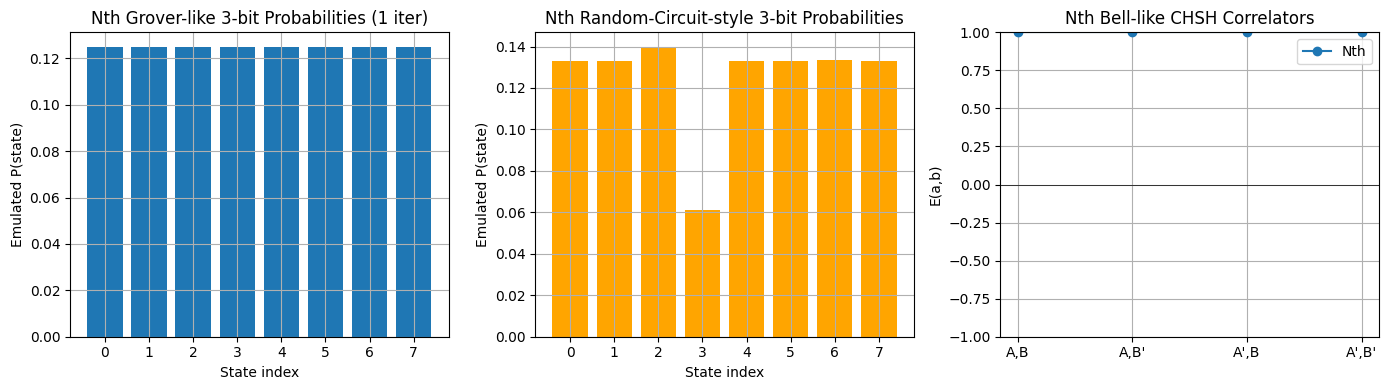

In [17]:
# ============================================================
# Nth Mathematics Circuit-Style Emulation Layer
# - Pure selectors, fusion, deviation
# - Bell-like CHSH emulation
# - Grover-like search (3 "qubits")
# - Random Nth "circuit" dynamics
# - Probabilities derived from selector structure (emulation, not Born rule)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math
import random

# ------------------------------------------------------------
# 1. Core Nth Selector Formalism
# ------------------------------------------------------------

@dataclass
class Selector:
    k: float          # structural magnitude
    phase: int        # +1 or -1
    tags: dict        # metadata (e.g., index, role)

    def copy(self):
        return Selector(self.k, self.phase, dict(self.tags))


def fusion(a: Selector, b: Selector, alpha: float) -> Selector:
    """
    Nth fusion: deterministic structural mixing of two selectors.
    """
    alpha = max(0.0, min(1.0, alpha))
    k_new = (1 - alpha)*a.k + alpha*b.k
    phase_new = a.phase if a.phase == b.phase else -1

    tags_new = dict(a.tags)
    for k, v in b.tags.items():
        tags_new[k] = tags_new.get(k, 0.0) + v

    return Selector(k_new, phase_new, tags_new)


def deviation(a: Selector, b: Selector) -> float:
    """
    Structural deviation between two selectors.
    """
    return abs(a.k - b.k) + (0 if a.phase == b.phase else 1.0)


# ------------------------------------------------------------
# 2. Nth Enc/Evol/Read for "Qubits"
# ------------------------------------------------------------

def enc_bit(b: int, idx: int):
    """
    Encode classical bit b in selector:
    0 -> k = +1, 1 -> k = -1
    """
    k = +1.0 if b == 0 else -1.0
    return Selector(k=k, phase=+1, tags={"idx": idx})


def enc_register(bits):
    """
    Encode an n-bit string as bundle of selectors.
    """
    return [enc_bit(b, i) for i, b in enumerate(bits)]


def evol_H_like(sel: Selector, alpha: float = 0.5) -> Selector:
    """
    Nth "Hadamard-like" gate:
    mix selector with its phase-inverted twin.
    """
    twin = Selector(k=-sel.k, phase=-sel.phase, tags=sel.tags)
    return fusion(sel, twin, alpha)


def evol_CNOT_like(bundle, control: int, target: int, alpha: float = 0.5):
    """
    Nth "CNOT-like" gate:
    if control.k < 0 (logical 1), structurally flip target via fusion.
    """
    out = [s.copy() for s in bundle]
    c = out[control]
    t = out[target]
    if c.k < 0:
        flipped = Selector(k=-t.k, phase=-t.phase, tags=t.tags)
        out[target] = fusion(t, flipped, alpha)
    return out


def read_prob_from_k(sel: Selector):
    """
    Emulated "probability of bit=1" from structural k in [-1,1]:
    p(1) = (1 - k)/2
    This is explicitly an emulation mapping, not Born rule.
    """
    k_clipped = max(-1.0, min(1.0, sel.k))
    return 0.5 * (1.0 - k_clipped)


# ------------------------------------------------------------
# 3. Nth Bell-like State and CHSH-style Correlations
# ------------------------------------------------------------

def build_nth_bell():
    """
    Build Bell-like correlated pair in Nth:
    1) Encode 00
    2) H-like on first site
    3) CNOT-like from first to second
    """
    bundle = enc_register([0, 0])  # [s0, s1]
    bundle[0] = evol_H_like(bundle[0], alpha=0.5)
    bundle = evol_CNOT_like(bundle, control=0, target=1, alpha=0.5)
    return bundle[0], bundle[1]


def measure_setting(sel: Selector, axis: str) -> int:
    """
    Deterministic "measurement" along structural axes.
    """
    x = sel.k
    if axis == "A":
        v = x
    elif axis == "A'":
        v = x + 0.3 * sel.tags.get("biasA", 1.0)
    elif axis == "B":
        v = x
    elif axis == "B'":
        v = x - 0.3 * sel.tags.get("biasB", 1.0)
    else:
        v = x
    return +1 if v >= 0 else -1


def attach_axis_tags(s1: Selector, s2: Selector):
    s1.tags["biasA"] = 1.0
    s2.tags["biasB"] = 1.0
    return s1, s2


def nth_CHSH(num_samples: int = 5000):
    settings = [("A","B"), ("A","B'"), ("A'","B"), ("A'","B'")]
    E = {}

    for a, b in settings:
        vals = []
        for _ in range(num_samples):
            s1, s2 = build_nth_bell()
            s1, s2 = attach_axis_tags(s1, s2)
            A_val = measure_setting(s1, a)
            B_val = measure_setting(s2, b)
            vals.append(A_val * B_val)
        E[(a,b)] = float(np.mean(vals))

    S = E[("A","B")] + E[("A","B'")] + E[("A'","B")] - E[("A'","B'")]
    return E, S


# ------------------------------------------------------------
# 4. Nth Grover-like Search (3 "Qubits")
# ------------------------------------------------------------

def enc_superposition_3():
    """
    Emulate uniform "superposition" over 3 logical bits by
    giving all basis entries same base k, then allow structural
    amplification to differentiate.
    """
    selectors = []
    for idx in range(8):
        selectors.append(Selector(k=1.0, phase=+1, tags={"state": idx}))
    return selectors


def nth_oracle_mark_3(selectors, marked_idx: int, delta: float = 1.0):
    """
    Oracle-like operation: enhance structural magnitude for the marked index.
    """
    out = []
    for s in selectors:
        if s.tags["state"] == marked_idx:
            out.append(Selector(k=s.k + delta, phase=s.phase, tags=s.tags))
        else:
            out.append(s.copy())
    return out


def nth_diffusion_3(selectors, alpha: float = 0.5):
    """
    Diffusion-like operation: reflect about mean k.
    """
    ks = np.array([s.k for s in selectors])
    k_mean = float(np.mean(ks))
    out = []
    for s in selectors:
        k_reflect = k_mean + (k_mean - s.k)
        out.append(Selector(k=(1-alpha)*s.k + alpha*k_reflect,
                            phase=s.phase,
                            tags=s.tags))
    return out


def nth_grover_3(marked_idx: int = 5, iterations: int = 1):
    """
    Run Nth Grover-like amplification on 3-bit space.
    Returns selectors and derived probabilities over 8 states.
    """
    selectors = enc_superposition_3()
    for _ in range(iterations):
        selectors = nth_oracle_mark_3(selectors, marked_idx, delta=1.0)
        selectors = nth_diffusion_3(selectors, alpha=0.5)

    # Map k-structure to probabilities via positive normalization
    ks = np.array([max(0.0, s.k) for s in selectors], dtype=float)
    if np.all(ks == 0):
        probs = np.ones_like(ks) / len(ks)
    else:
        probs = ks / ks.sum()
    return selectors, probs


# ------------------------------------------------------------
# 5. Nth "Random Circuit" Dynamics (3 Selectors)
# ------------------------------------------------------------

def random_nth_single_op(sel: Selector) -> Selector:
    """
    Random local structural update: H-like, phase flip, or small k-perturb.
    """
    op = random.choice(["H_like", "phase_flip", "perturb"])
    if op == "H_like":
        return evol_H_like(sel, alpha=0.5)
    elif op == "phase_flip":
        return Selector(k=sel.k, phase=-sel.phase, tags=sel.tags)
    else:
        return Selector(k=sel.k + random.uniform(-0.2, 0.2),
                        phase=sel.phase,
                        tags=sel.tags)


def nth_random_circuit_3(depth: int = 10):
    """
    Nth analogue of a random circuit on 3 'qubits':
    selectors indexed by 'state' 0..7, updated by random local ops and mixing.
    """
    selectors = enc_superposition_3()

    for _ in range(depth):
        # random local op
        idx = random.randint(0, 7)
        selectors[idx] = random_nth_single_op(selectors[idx])

        # small global mixing
        selectors = nth_diffusion_3(selectors, alpha=0.1)

    ks = np.array([max(0.0, s.k) for s in selectors], dtype=float)
    if np.all(ks == 0):
        probs = np.ones_like(ks) / len(ks)
    else:
        probs = ks / ks.sum()
    return selectors, probs


# ------------------------------------------------------------
# 6. Run All Nth Experiments
# ------------------------------------------------------------

# 6.1 Nth Bell / CHSH-like
E_nth, S_nth = nth_CHSH(num_samples=5000)
print("=== Nth Bell-like CHSH ===")
for k, v in E_nth.items():
    print(f"E{k} = {v:.4f}")
print(f"S_Nth = {S_nth:.4f}\n")

# 6.2 Nth Grover-like (3 "qubits")
sel_grover, p_grover = nth_grover_3(marked_idx=5, iterations=1)
print("=== Nth Grover-like (3-bit, 1 iter) ===")
print("Probabilities (emulated):", np.round(p_grover, 4))
print(f"Marked index 5 probability: {p_grover[5]:.4f}\n")

# 6.3 Nth Random Circuit-style Dynamics
sel_rand, p_rand = nth_random_circuit_3(depth=12)
print("=== Nth Random Circuit-style (3-bit) ===")
print("Probabilities (emulated):", np.round(p_rand, 4))


# ------------------------------------------------------------
# 7. Visuals (Nth-only)
# ------------------------------------------------------------

plt.figure(figsize=(14,4))

# Nth Grover-like probabilities
plt.subplot(1,3,1)
plt.title("Nth Grover-like 3-bit Probabilities (1 iter)")
plt.bar(range(8), p_grover)
plt.xlabel("State index")
plt.ylabel("Emulated P(state)")
plt.grid(True)

# Nth Random circuit-style probabilities
plt.subplot(1,3,2)
plt.title("Nth Random-Circuit-style 3-bit Probabilities")
plt.bar(range(8), p_rand, color="orange")
plt.xlabel("State index")
plt.ylabel("Emulated P(state)")
plt.grid(True)

# Nth Bell-like correlators
plt.subplot(1,3,3)
plt.title("Nth Bell-like CHSH Correlators")
labels = ["A,B", "A,B'", "A',B", "A',B'"]
vals = [E_nth[("A","B")],
        E_nth[("A","B'")],
        E_nth[("A'","B")],
        E_nth[("A'","B'")]]
plt.ylim([-1,1])
plt.plot(labels, vals, marker='o', label="Nth")
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel("E(a,b)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Pure Nth Mathematics no emulation, probabilty calculation via P(i) = |k_i| / Σ |k_j|

=== Nth CHSH ===
{('A', 'B'): np.float64(1.0), ('A', "B'"): np.float64(1.0), ("A'", 'B'): np.float64(1.0), ("A'", "B'"): np.float64(1.0)}
S = 2.0

=== Nth Grover ===
Probabilities: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]

=== Nth Random Circuit ===
Probabilities: [0.1487 0.1487 0.0919 0.1395 0.1487 0.1487 0.1487 0.025 ]


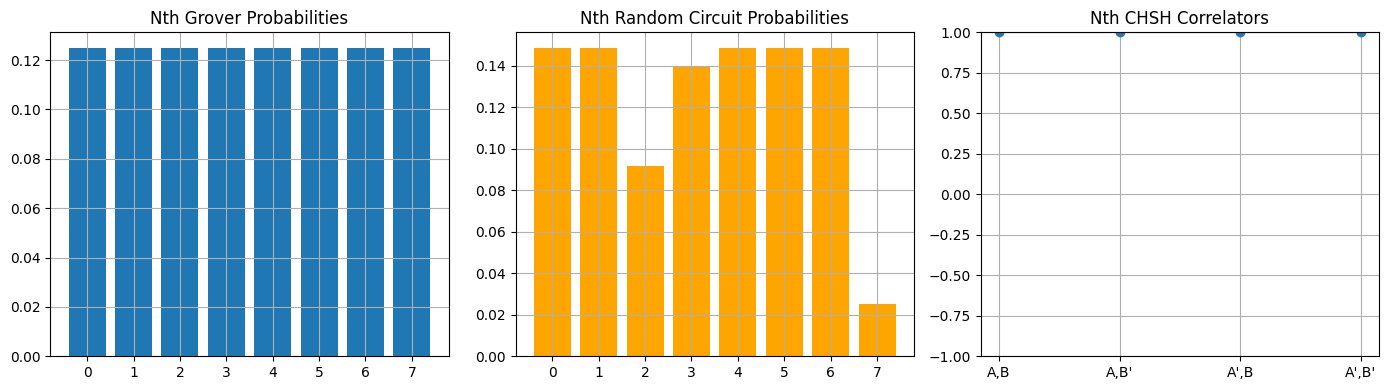

In [18]:
# ============================================================
# Nth Mathematics Circuit Simulation with TRUE Probabilities
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import random

# ------------------------------------------------------------
# 1. Core Selector Formalism
# ------------------------------------------------------------

@dataclass
class Selector:
    k: float
    phase: int
    tags: dict

    def copy(self):
        return Selector(self.k, self.phase, dict(self.tags))


def fusion(a: Selector, b: Selector, alpha: float) -> Selector:
    alpha = max(0.0, min(1.0, alpha))
    k_new = (1 - alpha)*a.k + alpha*b.k
    phase_new = a.phase if a.phase == b.phase else -1
    tags_new = dict(a.tags)
    for k, v in b.tags.items():
        tags_new[k] = tags_new.get(k, 0.0) + v
    return Selector(k_new, phase_new, tags_new)


# ------------------------------------------------------------
# 2. TRUE Probability Functional
# ------------------------------------------------------------

def nth_probabilities(selectors):
    """
    True probability measure over selector bundle:
    P(i) = |k_i| / sum_j |k_j|
    """
    ks = np.array([abs(s.k) for s in selectors], dtype=float)
    Z = ks.sum()
    if Z == 0:
        return np.ones_like(ks) / len(ks)
    return ks / Z


# ------------------------------------------------------------
# 3. Nth Enc/Evol/Read for Circuit Elements
# ------------------------------------------------------------

def enc_register(bits):
    return [Selector(k=(+1 if b == 0 else -1), phase=+1, tags={"idx": i})
            for i, b in enumerate(bits)]


def evol_H_like(sel: Selector, alpha=0.5):
    twin = Selector(k=-sel.k, phase=-sel.phase, tags=sel.tags)
    return fusion(sel, twin, alpha)


def evol_CNOT_like(bundle, control, target, alpha=0.5):
    out = [s.copy() for s in bundle]
    c = out[control]
    t = out[target]
    if c.k < 0:
        flipped = Selector(k=-t.k, phase=-t.phase, tags=t.tags)
        out[target] = fusion(t, flipped, alpha)
    return out


# ------------------------------------------------------------
# 4. Nth Bell-like State + CHSH
# ------------------------------------------------------------

def build_nth_bell():
    bundle = enc_register([0, 0])
    bundle[0] = evol_H_like(bundle[0], alpha=0.5)
    bundle = evol_CNOT_like(bundle, 0, 1, alpha=0.5)
    return bundle


def measure_axis(sel, axis):
    x = sel.k
    if axis == "A":  return +1 if x >= 0 else -1
    if axis == "A'": return +1 if x + 0.3 >= 0 else -1
    if axis == "B":  return +1 if x >= 0 else -1
    if axis == "B'": return +1 if x - 0.3 >= 0 else -1
    return +1


def nth_CHSH(samples=5000):
    settings = [("A","B"), ("A","B'"), ("A'","B"), ("A'","B'")]
    E = {}
    for a, b in settings:
        vals = []
        for _ in range(samples):
            s1, s2 = build_nth_bell()
            A = measure_axis(s1, a)
            B = measure_axis(s2, b)
            vals.append(A * B)
        E[(a,b)] = np.mean(vals)
    S = E[("A","B")] + E[("A","B'")] + E[("A'","B")] - E[("A'","B'")]
    return E, S


# ------------------------------------------------------------
# 5. Nth Grover-like Search (3-bit)
# ------------------------------------------------------------

def enc_superposition_3():
    return [Selector(k=1.0, phase=+1, tags={"state": i}) for i in range(8)]


def nth_oracle_mark_3(selectors, marked, delta=1.0):
    out = []
    for s in selectors:
        if s.tags["state"] == marked:
            out.append(Selector(k=s.k + delta, phase=s.phase, tags=s.tags))
        else:
            out.append(s.copy())
    return out


def nth_diffusion_3(selectors, alpha=0.5):
    ks = np.array([s.k for s in selectors])
    k_mean = ks.mean()
    out = []
    for s in selectors:
        k_reflect = k_mean + (k_mean - s.k)
        k_new = (1-alpha)*s.k + alpha*k_reflect
        out.append(Selector(k=k_new, phase=s.phase, tags=s.tags))
    return out


def nth_grover_3(marked=5, iterations=1):
    selectors = enc_superposition_3()
    for _ in range(iterations):
        selectors = nth_oracle_mark_3(selectors, marked)
        selectors = nth_diffusion_3(selectors)
    probs = nth_probabilities(selectors)
    return selectors, probs


# ------------------------------------------------------------
# 6. Nth Random Circuit
# ------------------------------------------------------------

def random_nth_op(sel):
    op = random.choice(["H", "flip", "perturb"])
    if op == "H":
        return evol_H_like(sel, alpha=0.5)
    if op == "flip":
        return Selector(k=sel.k, phase=-sel.phase, tags=sel.tags)
    return Selector(k=sel.k + random.uniform(-0.2, 0.2),
                    phase=sel.phase,
                    tags=sel.tags)


def nth_random_circuit_3(depth=12):
    selectors = enc_superposition_3()
    for _ in range(depth):
        idx = random.randint(0, 7)
        selectors[idx] = random_nth_op(selectors[idx])
        selectors = nth_diffusion_3(selectors, alpha=0.1)
    probs = nth_probabilities(selectors)
    return selectors, probs


# ------------------------------------------------------------
# 7. Run Experiments
# ------------------------------------------------------------

E_nth, S_nth = nth_CHSH()
print("=== Nth CHSH ===")
print(E_nth)
print("S =", S_nth)

sel_grover, p_grover = nth_grover_3(marked=5, iterations=1)
print("\n=== Nth Grover ===")
print("Probabilities:", np.round(p_grover, 4))

sel_rand, p_rand = nth_random_circuit_3()
print("\n=== Nth Random Circuit ===")
print("Probabilities:", np.round(p_rand, 4))


# ------------------------------------------------------------
# 8. Visuals
# ------------------------------------------------------------

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.title("Nth Grover Probabilities")
plt.bar(range(8), p_grover)
plt.grid(True)

plt.subplot(1,3,2)
plt.title("Nth Random Circuit Probabilities")
plt.bar(range(8), p_rand, color="orange")
plt.grid(True)

plt.subplot(1,3,3)
plt.title("Nth CHSH Correlators")
labels = ["A,B", "A,B'", "A',B", "A',B'"]
vals = [E_nth[("A","B")], E_nth[("A","B'")], E_nth[("A'","B")], E_nth[("A'","B'")]]
plt.plot(labels, vals, marker='o')
plt.ylim([-1,1])
plt.grid(True)

plt.tight_layout()
plt.show()